In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Neue Notenumformung nach Jens (viel langsamer, aber ey...)
def toNote(erreichtePunkte):
    punkte = np.floor(erreichtePunkte*(20/100))
    if punkte < 10: return 5.0
    elif punkte >= 19: return 1.0
    else: return {10: 4.0,
                  11: 3.7,
                  12: 3.3,
                  13: 3.0,
                  14: 2.7,
                  15: 2.3,
                  16: 2.0,
                  17: 1.7,
                  18: 1.3}[punkte]
toNote = np.vectorize(toNote)

# Johannes Datensatz

In [3]:
daten = pd.read_csv("Datensätze/info1_1617/info1_1617_gesamt.csv") 

#Erstelle df, alle Wichtigen Features
df = pd.DataFrame()

spalten = ["summe-blatt"+str(i) for i in range(1,13)] + ["summe-uebungs-punkte","pruefungsversuch"]
df[spalten] = daten[spalten].fillna(0)

df = df.astype(float)

df["klausur-punkte"] = daten["summe-klausur-punkte"]
df["note"] = daten["note"].str.replace(',','.').astype(float)

#Nachbildung seiner Selektierung
klausur_ausreichendePunkte = df[((df["pruefungsversuch"]==1) | (df["pruefungsversuch"]==0)) & df["note"].notna() & (df["summe-uebungs-punkte"]>=600)]
keineKlausur_mangelndePunkte = df[daten["summe-uebungs-punkte"].notna() & ((df["pruefungsversuch"]==1) | (df["pruefungsversuch"]==0)) & df["note"].isna() & (df["summe-uebungs-punkte"]<600)]

johannes = pd.concat([klausur_ausreichendePunkte, keineKlausur_mangelndePunkte]).drop(["pruefungsversuch"], axis=1)

blaetterBearbeitet = (johannes[["summe-blatt"+str(i) for i in range(1,13)]]!=0).sum(axis=1)
johannes["uebungspunkte-pro-blatt"] = (johannes["summe-uebungs-punkte"] / blaetterBearbeitet).fillna(0)

johannes["klausur-punkte"].fillna(0, inplace = True)

johannes["note-korrigiert"] = 6.0
johannes["note-korrigiert"][johannes["summe-uebungs-punkte"]>=600] = toNote(johannes["klausur-punkte"][johannes["summe-uebungs-punkte"]>=600])

display(johannes)

,summe-blatt1,summe-blatt2,summe-blatt3,summe-blatt4,summe-blatt5,summe-blatt6,summe-blatt7,summe-blatt8,summe-blatt9,summe-blatt10,summe-blatt11,summe-blatt12,summe-uebungs-punkte,klausur-punkte,note,uebungspunkte-pro-blatt,note-korrigiert
0,100.0,100.0,95.0,85.0,125.0,0.0,100.0,118.0,0.0,0.0,0.0,0.0,723.0,89.0,1.7,103.285714,1.7
1,100.0,99.0,100.0,90.0,125.0,108.0,100.0,0.0,0.0,33.0,0.0,100.0,855.0,80.0,2.0,95.000000,2.0
6,100.0,95.0,100.0,100.0,125.0,105.0,50.0,0.0,0.0,0.0,0.0,0.0,675.0,82.0,2.0,96.428571,2.0
8,94.0,38.0,100.0,100.0,125.0,110.0,100.0,125.0,97.0,105.0,0.0,55.0,1049.0,72.0,2.7,95.363636,2.7
11,100.0,95.0,100.0,100.0,125.0,101.0,100.0,125.0,50.0,84.0,122.0,85.0,1187.0,72.0,2.7,98.916667,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,0.0,NaN,68.000000,6.0
819,0.0,0.0,40.0,55.0,75.0,0.0,70.0,50.0,0.0,0.0,0.0,0.0,290.0,0.0,NaN,58.000000,6.0
820,80.0,62.0,28.0,49.0,45.0,26.0,34.0,69.0,0.0,29.0,49.0,0.0,471.0,0.0,NaN,47.100000,6.0
822,95.0,95.0,20.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,235.0,0.0,NaN,58.750000,6.0


## Vorhersage auf Johannes Datensatz

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score

def regression(einflussdaten, zieldaten, maxGrad=10):
    gridSearch = pd.DataFrame(columns=["Grad","MAE (Noten)", "MSE (Noten)", "R2"])
    for grad in range(1, maxGrad+1):
        vorhersage = np.array([])
        real = np.array([])
        poly = PolynomialFeatures(grad)
        for train, test in LeaveOneOut().split(einflussdaten):
            X_train, X_test, y_train, y_test = einflussdaten.iloc[train], einflussdaten.iloc[test], zieldaten.iloc[train], float(zieldaten.iloc[test])
            transform_X_train = poly.fit_transform(X_train)
            linReg = LinearRegression()
            linReg.fit(transform_X_train, y_train)
            
            transform_X_test = poly.fit_transform(X_test)
            vorhersage = np.append(vorhersage, [linReg.predict(transform_X_test)[0]])
            real = np.append(real, [y_test])
        
        real = np.append(real, johannes["klausur-punkte"][johannes["summe-uebungs-punkte"]<600])
        vorhersage = np.append(vorhersage, [0]*len(johannes["klausur-punkte"][johannes["summe-uebungs-punkte"]<600]))

        r2 = round(r2_score(real, vorhersage),4)
        
        real = toNote(real)
        vorhersage = toNote(vorhersage)
        mae = round(np.mean(abs(vorhersage-real)),3)
        mse = round(np.mean((vorhersage-real)**2),3)
           
        gridSearch.loc[grad] = [grad, mae, mse, r2]
    return gridSearch

regression_einfach = regression(johannes[["summe-uebungs-punkte", "uebungspunkte-pro-blatt"]][johannes["summe-uebungs-punkte"]>=600], johannes["klausur-punkte"][johannes["summe-uebungs-punkte"]>=600], maxGrad=15)
display(regression_einfach)

,Grad,MAE (Noten),MSE (Noten),R2
1,1.0,0.494,0.713,0.8744
2,2.0,0.472,0.683,0.8773
3,3.0,0.492,0.740,0.8759
4,4.0,0.473,0.709,0.8755
5,5.0,0.476,0.722,0.8462
6,6.0,0.480,0.762,0.8295
7,7.0,0.479,0.764,0.7598
8,8.0,0.474,0.738,0.8317
9,9.0,0.478,0.733,0.8371
10,10.0,0.475,0.711,0.8414


# Rechnerarchitektur

## Maximalpunkte:
### 30, 25, 25, 29, 20, 25, 30, 30, 30, 30, 40

,Matriculation,Blatt1,Blatt2,Blatt3,Blatt4,Blatt5,Blatt6,Blatt7,Blatt8,Blatt9,Blatt10,Blatt11,Summe,Versuch,Note,erwartete-note
0,1.0,24.0,4.0,15.0,13.0,14.0,13.0,4.0,9.0,9.0,26.0,27.0,158.0,1.0,2.3,3.7
1,2.0,30.0,23.0,11.0,8.0,7.0,NaN,6.0,28.0,19.0,13.0,18.0,163.0,1.0,1.7,3.7
2,3.0,26.0,15.0,19.0,21.0,NaN,NaN,10.0,14.0,0.0,28.0,21.0,154.0,1.0,1.7,3.7
3,4.0,30.0,16.0,17.0,NaN,7.0,5.0,10.0,NaN,10.0,28.0,25.0,148.0,1.0,2.0,4.0
4,5.0,13.0,9.0,9.0,16.0,16.0,20.0,13.0,2.0,25.0,28.0,27.0,178.0,1.0,1.3,3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,209.0,26.0,25.0,25.0,5.0,15.0,24.0,30.0,28.0,28.0,NaN,27.0,233.0,1.0,1.7,2.0
209,210.0,29.0,23.0,25.0,10.0,NaN,NaN,30.0,11.0,28.0,27.0,NaN,183.0,1.0,3.7,2.7
210,211.0,17.0,19.0,24.0,23.0,16.0,21.0,NaN,24.0,15.0,26.0,24.0,209.0,1.0,4.0,2.7
211,212.0,30.0,23.0,10.0,NaN,5.0,20.0,NaN,19.0,23.0,30.0,15.0,175.0,1.0,3.3,3.3


Durchschnitt Note: 2.95 ohne 5: 2.65
Durchschnitt prognose: 2.7 ohne 5: 2.73
Abweichung: 0.25 ohne 5: 0.08
Durchschnittliche absolute Abweichung: 1.26 ohne 5: 1.07
Durchschnittliche quadratische Abweichung: 2.32 ohne 5: 1.63


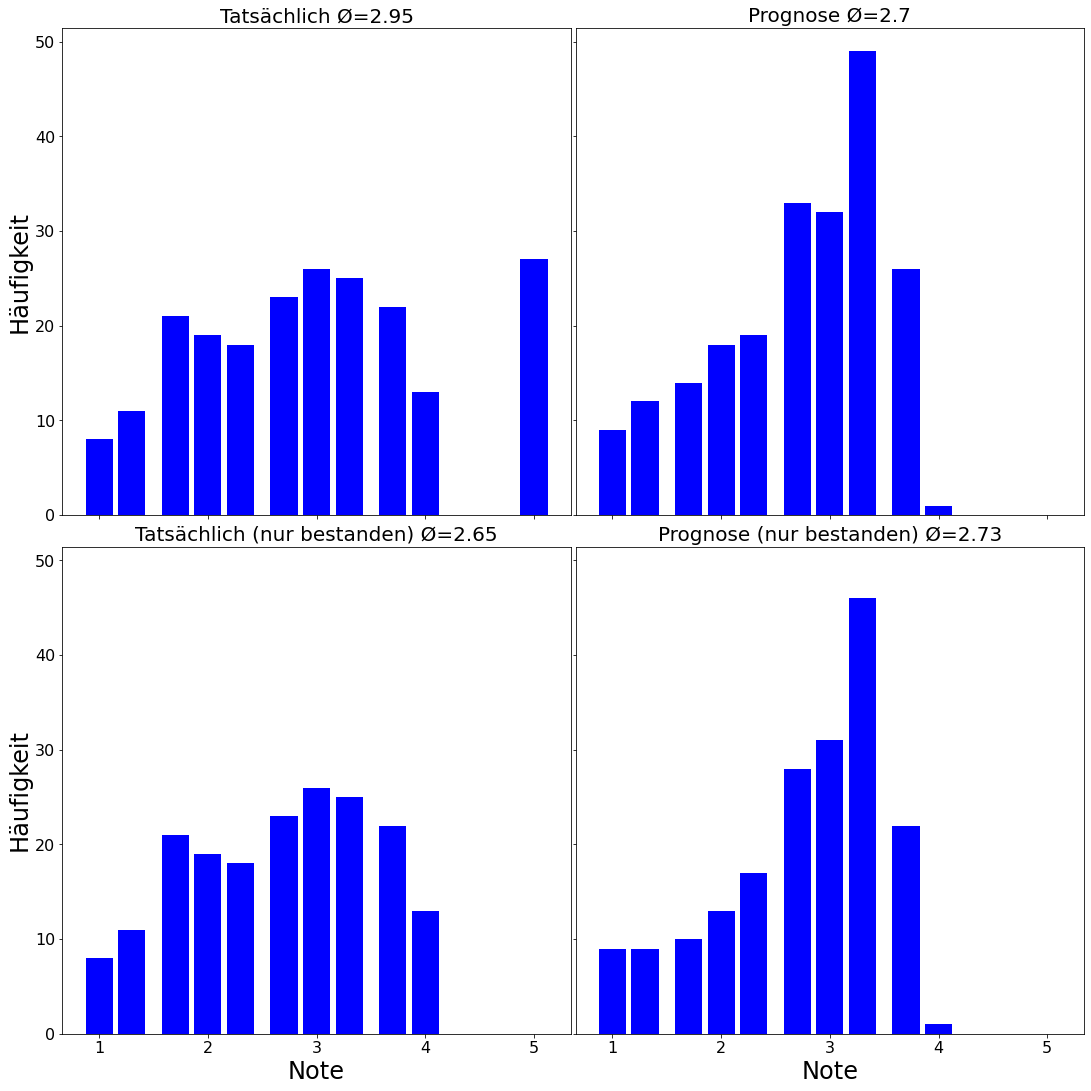

In [5]:
kurs1 = pd.read_csv("Datensätze/Rechnerarchitektur/kurs1.csv")

display(kurs1)

print("Durchschnitt Note:", round(sum(kurs1["Note"])/len(kurs1["Note"]),2), "ohne 5:", round(sum(kurs1["Note"][kurs1["Note"]<5.0])/len(kurs1["Note"][kurs1["Note"]<5.0]),2))
print("Durchschnitt prognose:", round(sum(kurs1["erwartete-note"])/len(kurs1["erwartete-note"]),2), "ohne 5:", round(sum(kurs1["erwartete-note"][kurs1["Note"]<5.0])/len(kurs1["erwartete-note"][kurs1["Note"]<5.0]),2))
print("Abweichung:", round(abs(2.95-2.7),2), "ohne 5:", round(abs(2.65-2.73),2))
print("Durchschnittliche absolute Abweichung:", round(sum(abs(kurs1["Note"]-kurs1["erwartete-note"]))/len(kurs1["Note"]),2),
      "ohne 5:", round(sum(abs(kurs1["Note"][kurs1["Note"]<5.0]-kurs1["erwartete-note"][kurs1["Note"]<5.0]))/len(kurs1["Note"][kurs1["Note"]<5.0]),2))
print("Durchschnittliche quadratische Abweichung:", round(sum((kurs1["Note"]-kurs1["erwartete-note"])**2)/len(kurs1["Note"]),2),
       "ohne 5:", round(sum((kurs1["Note"][kurs1["Note"]<5.0]-kurs1["erwartete-note"][kurs1["Note"]<5.0])**2)/len(kurs1["Note"][kurs1["Note"]<5.0]),2))

plt.rcParams['font.size'] = 16
fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharex="all", sharey="all")

kurs1_noten_haeufigkeit = kurs1["Note"].value_counts()
axs[0][0].bar(kurs1_noten_haeufigkeit.index.tolist(), kurs1_noten_haeufigkeit.values, width=0.25, color="b")
axs[0][0].set_ylabel("Häufigkeit", fontsize=24)
axs[0][0].set_title("Tatsächlich \u00D8=2.95", fontsize=20)

kurs1_eNoten_haeufigkeit = kurs1["erwartete-note"].value_counts()
axs[0][1].bar(kurs1_eNoten_haeufigkeit.index.tolist(), kurs1_eNoten_haeufigkeit.values, width=0.25, color="b")
axs[0][1].set_title("Prognose \u00D8=2.7", fontsize=20)

kurs1_notenBestanden_haeufigkeit = kurs1["Note"][kurs1["Note"]<5.0].value_counts()
axs[1][0].bar(kurs1_notenBestanden_haeufigkeit.index.tolist(), kurs1_notenBestanden_haeufigkeit.values, width=0.25, color="b")
axs[1][0].set_ylabel("Häufigkeit", fontsize=24)
axs[1][0].set_xlabel("Note", fontsize=24)
axs[1][0].set_title("Tatsächlich (nur bestanden) \u00D8=2.65", fontsize=20)

kurs1_eNotenBestanden_haeufigkeit = kurs1["erwartete-note"][kurs1["Note"]<5.0].value_counts()
axs[1][1].bar(kurs1_eNotenBestanden_haeufigkeit.index.tolist(), kurs1_eNotenBestanden_haeufigkeit.values, width=0.25, color="b")
axs[1][1].set_xlabel("Note", fontsize=24)
axs[1][1].set_title("Prognose (nur bestanden) \u00D8=2.73", fontsize=20)

plt.tight_layout(pad=0.1)
plt.show()

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(kurs1)

# Informatik 1

## Maximalpunkte:
### 60, 60, 60, 80, 60, 60, 70, 80, 140, 60, 60

,id,Blatt 1,Blatt 2,Blatt 3,Blatt 4,Blatt 5,Blatt 6,Blatt 7,Blatt 8,Blatt 9,Blatt 10,Blatt 11,klausur,Summe,erwartete-note,Note
1,2.0,42.0,51.0,40.0,78.0,22.5,22.5,26.5,37.5,104.5,31.0,22.0,75.0,477.5,3.3,2.0
2,3.0,51.0,54.0,34.0,73.0,8.5,8.5,20.0,45.5,57.5,0.0,0.0,34.0,352.0,4.0,5.0
3,4.0,48.0,52.0,32.0,51.0,40.0,40.0,31.0,35.0,75.0,12.0,30.0,45.0,446.0,3.3,4.0
4,5.0,53.0,34.0,19.0,42.0,27.0,27.0,13.0,52.0,121.0,46.5,44.5,55.0,479.0,3.3,3.3
7,8.0,55.0,53.0,10.0,60.0,24.0,24.0,25.0,28.0,67.5,30.0,0.0,17.5,376.5,3.7,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,585.0,51.0,39.0,58.0,80.0,44.0,44.0,60.0,37.0,97.0,12.0,2.0,41.0,524.0,3.0,5.0
585,586.0,52.0,30.0,0.0,52.0,20.0,20.0,0.0,45.5,57.0,30.0,10.0,17.5,316.5,5.0,5.0
587,588.0,56.0,53.0,50.0,80.0,0.0,0.0,40.0,55.0,71.0,55.0,11.0,72.0,471.0,3.0,2.0
588,589.0,60.0,60.0,60.0,80.0,60.0,60.0,59.0,58.0,129.5,57.0,57.0,78.5,740.5,1.0,1.7


Durchschnitt Note: 3.46 ohne 0er: 3.44
Durchschnitt Prognose: 3.33 ohne 0er: 3.32
Abweichung: 0.13 ohne 0er: 0.12
Durchschnittliche absolute Abweichung: 0.8 ohne 0er: 0.8
Durchschnittliche quadratische Abweichung: 1.07 ohne 0er: 1.07


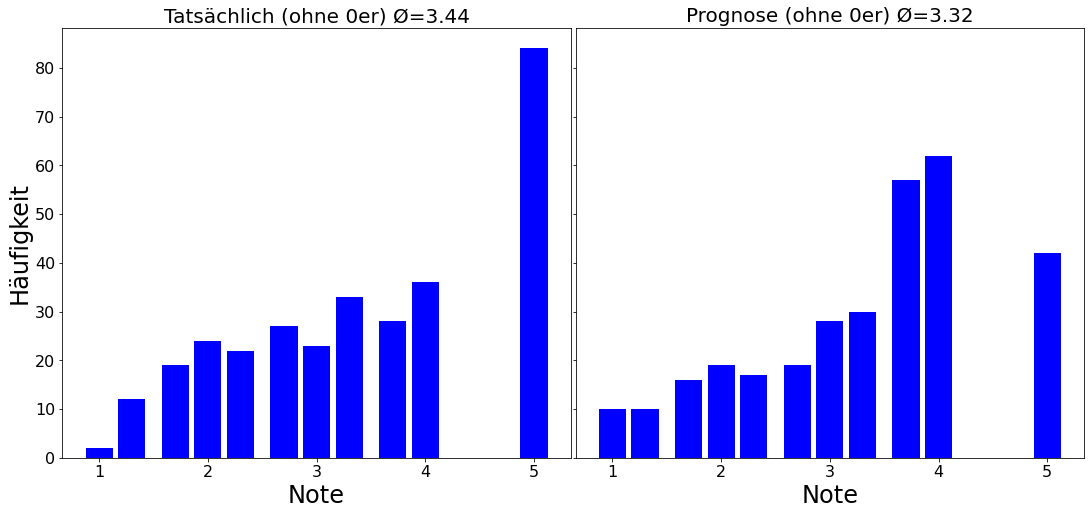

In [6]:
uebung = pd.read_csv("Datensätze/Informatik1/uebung.csv")

uebung_klausur = uebung[uebung["klausur"].notna()].copy()
uebung_klausur["Note"] = toNote(uebung_klausur["klausur"]*(100/90))
display(uebung_klausur)

print("Durchschnitt Note:", round(sum(uebung_klausur["Note"])/len(uebung_klausur["Note"]),2), "ohne 0er:", round(sum(uebung_klausur["Note"][uebung_klausur["klausur"]>0])/len(uebung_klausur["Note"][uebung_klausur["klausur"]>0]),2))
print("Durchschnitt Prognose:", round(sum(uebung_klausur["erwartete-note"])/len(uebung_klausur["erwartete-note"]),2), "ohne 0er:", round(sum(uebung_klausur["erwartete-note"][uebung_klausur["klausur"]>0])/len(uebung_klausur["erwartete-note"][uebung_klausur["klausur"]>0]),2))
print("Abweichung:", round(abs(3.46-3.33),2), "ohne 0er:", round(abs(3.44-3.32),2))
print("Durchschnittliche absolute Abweichung:", round(sum(abs(uebung_klausur["Note"]-uebung_klausur["erwartete-note"]))/len(uebung_klausur["Note"]),2),
     "ohne 0er:", round(sum(abs(uebung_klausur["Note"][uebung_klausur["klausur"]>0]-uebung_klausur["erwartete-note"][uebung_klausur["klausur"]>0]))/len(uebung_klausur["Note"][uebung_klausur["klausur"]>0]),2))
print("Durchschnittliche quadratische Abweichung:", round(sum((uebung_klausur["Note"]-uebung_klausur["erwartete-note"])**2)/len(uebung_klausur["Note"]),2),
       "ohne 0er:", round(sum((uebung_klausur["Note"][uebung_klausur["klausur"]>0]-uebung_klausur["erwartete-note"][uebung_klausur["klausur"]>0])**2)/len(uebung_klausur["Note"][uebung_klausur["klausur"]>0]),2))

plt.rcParams['font.size'] = 16
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharex="all", sharey="all")

uebung_noten_haeufigkeit = uebung_klausur["Note"][uebung_klausur["klausur"]>0].value_counts()
axs[0].bar(uebung_noten_haeufigkeit.index.tolist(), uebung_noten_haeufigkeit.values, width=0.25, color="b")
axs[0].set_xlabel("Note", fontsize=24)
axs[0].set_ylabel("Häufigkeit", fontsize=24)
axs[0].set_title("Tatsächlich (ohne 0er) \u00D8=3.44", fontsize=20)

uebung_eNoten_haeufigkeit = uebung_klausur["erwartete-note"][uebung_klausur["klausur"]>0].value_counts()
axs[1].bar(uebung_eNoten_haeufigkeit.index.tolist(), uebung_eNoten_haeufigkeit.values, width=0.25, color="b")
axs[1].set_title("Prognose (ohne 0er) \u00D8=3.32", fontsize=20)
axs[1].set_xlabel("Note", fontsize=24)

plt.tight_layout(pad=0.1)
plt.show()

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(uebung)

# Theoretische Informatik

## Maximalpunkte:
### 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 8

,id,Blatt 1,Blatt 2,Blatt 3,Blatt 4,Blatt 5,Blatt 6,Blatt 7,Blatt 8,Blatt 9,Blatt 10,Blatt 11,klausur,Summe,erwartete-note,Note
0,1.0,2.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,13.0,5.0,5.0
2,3.0,7.0,5.0,4.0,5.0,0.0,4.0,2.0,4.0,3.0,2.0,5.0,50.0,41.0,4.0,3.7
4,5.0,8.0,8.0,7.0,7.0,6.0,4.0,7.0,6.0,8.0,9.0,0.0,0.0,70.0,2.0,5.0
5,6.0,8.0,4.0,8.0,8.0,6.0,5.0,7.0,4.0,8.0,8.0,0.0,52.0,66.0,2.3,3.7
8,9.0,8.0,6.0,8.0,5.0,6.0,6.0,4.0,3.0,0.0,0.0,0.0,66.0,46.0,3.3,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,327.0,8.0,8.0,2.0,0.0,0.0,6.0,7.0,5.0,4.0,6.0,0.0,41.0,46.0,3.7,5.0
327,328.0,8.0,7.0,8.0,6.0,8.0,8.0,5.0,5.0,5.0,3.0,3.0,48.0,66.0,2.3,4.0
331,332.0,7.0,8.0,8.0,8.0,5.0,6.0,7.0,6.0,6.0,0.0,0.0,61.0,61.0,2.3,3.0
338,339.0,7.0,7.0,7.0,6.0,4.0,7.0,5.0,0.0,0.0,0.0,0.0,28.0,43.0,3.3,5.0


Durchschnitt Note: 3.93 ohne 0er: 3.87
Durchschnitt Prognose: 3.55 ohne 0er: 3.55
Abweichung: 0.38 ohne 0er: 0.32
Durchschnittliche absolute Abweichung: 0.81 ohne 0er: 0.78
Durchschnittliche quadratische Abweichung: 1.02 ohne 0er: 0.93


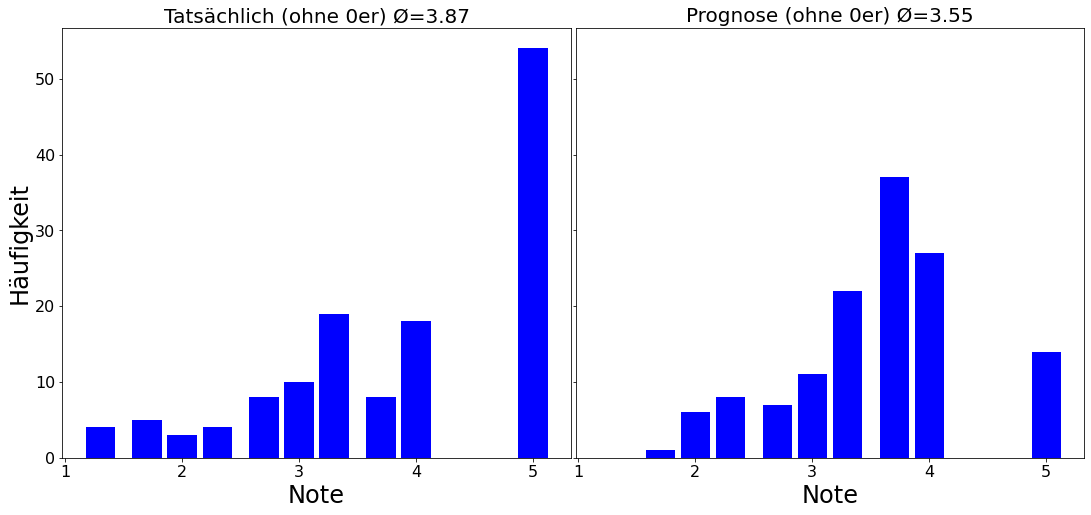

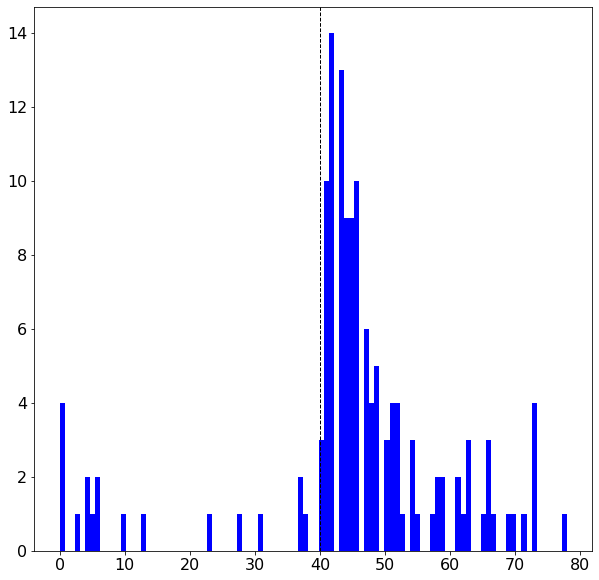

In [7]:
ti = pd.read_csv("Datensätze/Theoretische Informatik/ti.csv")
#display(ti)
ti_klausur = ti[ti["klausur"].notna()].copy()
ti_klausur["Note"] = toNote(ti_klausur["klausur"]*(100/90))
display(ti_klausur)

print("Durchschnitt Note:", round(sum(ti_klausur["Note"])/len(ti_klausur["Note"]),2), "ohne 0er:", round(sum(ti_klausur["Note"][ti_klausur["klausur"]>0])/len(ti_klausur["Note"][ti_klausur["klausur"]>0]),2))
print("Durchschnitt Prognose:", round(sum(ti_klausur["erwartete-note"])/len(ti_klausur["erwartete-note"]),2), "ohne 0er:", round(sum(ti_klausur["erwartete-note"][ti_klausur["klausur"]>0])/len(ti_klausur["erwartete-note"][ti_klausur["klausur"]>0]),2))
print("Abweichung:", round(abs(3.93-3.55),2), "ohne 0er:", round(abs(3.87-3.55),2))
print("Durchschnittliche absolute Abweichung:", round(sum(abs(ti_klausur["Note"]-ti_klausur["erwartete-note"]))/len(ti_klausur["Note"]),2),
     "ohne 0er:", round(sum(abs(ti_klausur["Note"][ti_klausur["klausur"]>0]-ti_klausur["erwartete-note"][ti_klausur["klausur"]>0]))/len(ti_klausur["Note"][ti_klausur["klausur"]>0]),2))
print("Durchschnittliche quadratische Abweichung:", round(sum((ti_klausur["Note"]-ti_klausur["erwartete-note"])**2)/len(ti_klausur["Note"]),2),
       "ohne 0er:", round(sum((ti_klausur["Note"][ti_klausur["klausur"]>0]-ti_klausur["erwartete-note"][ti_klausur["klausur"]>0])**2)/len(ti_klausur["Note"][ti_klausur["klausur"]>0]),2))

plt.rcParams['font.size'] = 16
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharex="all", sharey="all")

ti_noten_haeufigkeit = ti_klausur["Note"][ti_klausur["klausur"]>0].value_counts()
axs[0].bar(ti_noten_haeufigkeit.index.tolist(), ti_noten_haeufigkeit.values, width=0.25, color="b")
axs[0].set_xlabel("Note", fontsize=24)
axs[0].set_ylabel("Häufigkeit", fontsize=24)
axs[0].set_title("Tatsächlich (ohne 0er) \u00D8=3.87", fontsize=20)
axs[0].set_xticks([1,2,3,4,5])

ti_eNoten_haeufigkeit = ti_klausur["erwartete-note"][ti_klausur["klausur"]>0].value_counts()
axs[1].bar(ti_eNoten_haeufigkeit.index.tolist(), ti_eNoten_haeufigkeit.values, width=0.25, color="b")
axs[1].set_xlabel("Note", fontsize=24)
axs[1].set_title("Prognose (ohne 0er) \u00D8=3.55", fontsize=20)
axs[1].set_xticks([1,2,3,4,5])

plt.tight_layout(pad=0.1)
plt.show()

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(ti)

plt.figure(figsize=(10, 10))
plt.hist(ti_klausur["Summe"], bins=100, color="b")
plt.axvline(x=40, color="black", linestyle="--", linewidth=1)
plt.show()